DJI Matrice 600 data processing notebook

In [1]:
import matplotlib as mpl
import matplotlib.cm
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.mlab as mlab
from mpl_toolkits.mplot3d import Axes3D 
import numpy as np
import pandas as pd
import pymap3d as pm
#from math import *
from datetime import datetime
from matplotlib.transforms import offset_copy
from matplotlib.ticker import FormatStrFormatter
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import geopy.distance
from scalebar import scale_bar #requires the existance of scalebar.py
import pyproj
from scipy.stats import norm

import drone

plt.rcParams["figure.figsize"] = (8,8)


In [18]:
#process the files
# USEFUL FILES:
# FLY188: Monday morning grid
# FLY189: Monday morning RFI
# FLY191: Monday afternoon
# FLY196: Tuesday morning RFI
# FLY197: Tuesday morning noise source on
# FLY200: Tuesday afternoon absolute GPS test
# FLY203: Wednesday morning
# FLY204: Wednesday morning
# FLY206_FLY207_FLY208_FLY209_FLY210: Wednesday afternoon absolute
# FLY215: Thursday morning beam map
# 222, 224, 225, 226, 229


# Write down the name of our file for future reference
#NAMES = ['FLY222', 'FLY224', 'FLY225', 'FLY226', 'FLY229']
NAMES = ['FLY235', 'FLY236']

#drone.process_files([NAME])


In [19]:
# read all the files into an array of droneData objects

drone_data = []

for NAME in NAMES:
    df = pd.read_csv("./csv_out/"+NAME+"_processed.csv", sep=',', header=0)

    df = df.assign(timestamp = pd.to_datetime(df['timestamp'].values))
    df = df.where(df != 0.) 
    df.dropna(thresh=2, inplace=True)
    drone_data.append(drone.DroneData(df, NAME))


In [20]:
# fill in the extra files

for dat in drone_data: 
    dat.fill_moving()
    dat.fill_avMov()
    if 'FLY222' in NAMES:
        dat.make_ENU(lat_origin=37.233421310110394, lon_origin=-118.2836256870619)
    if 'FLY235' in NAMES:
        dat.make_ENU(lat_origin=41.210662930555555, lon_origin=-73.04671158611111)

3.169869
41.21066293055556
-73.04671158611112
0.93192405
41.21066293055556
-73.04671158611112


In [21]:
#for dat in drone_data:
#    dat.plot_satellite()


<IPython.core.display.Javascript object>


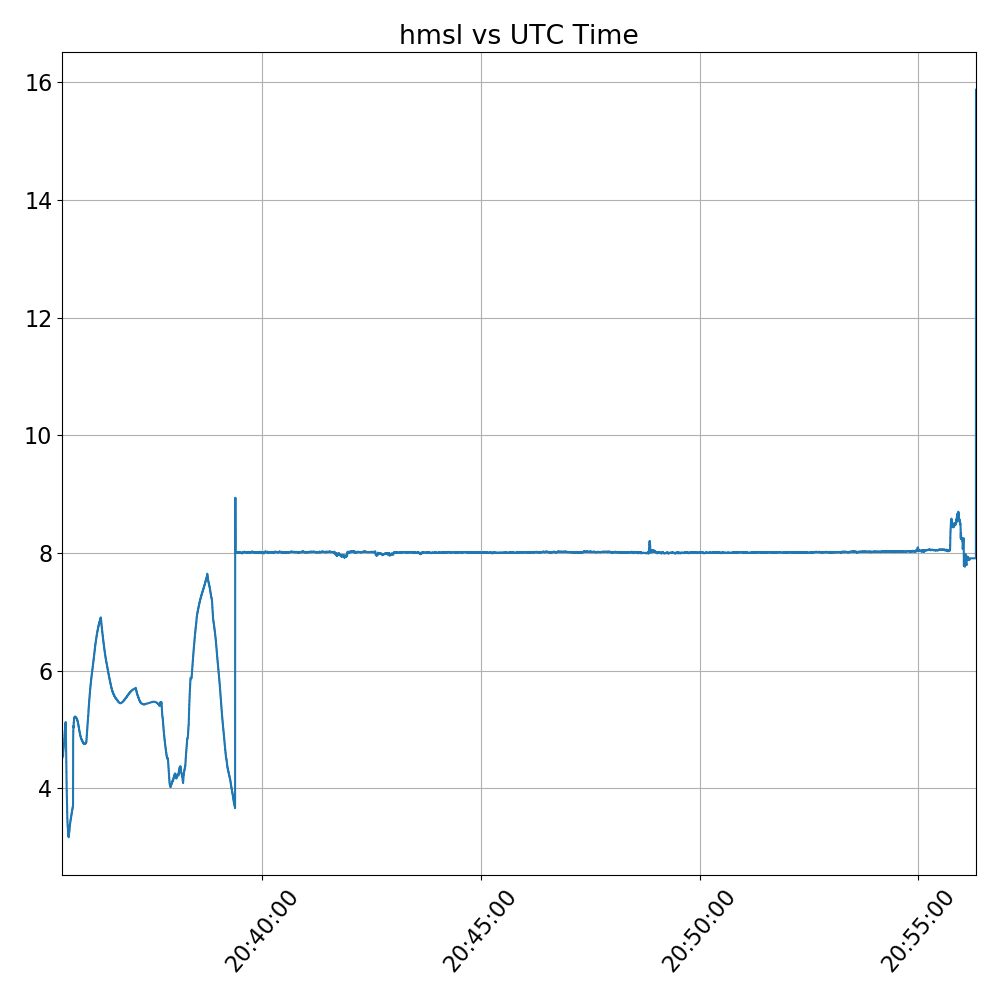

<IPython.core.display.Javascript object>


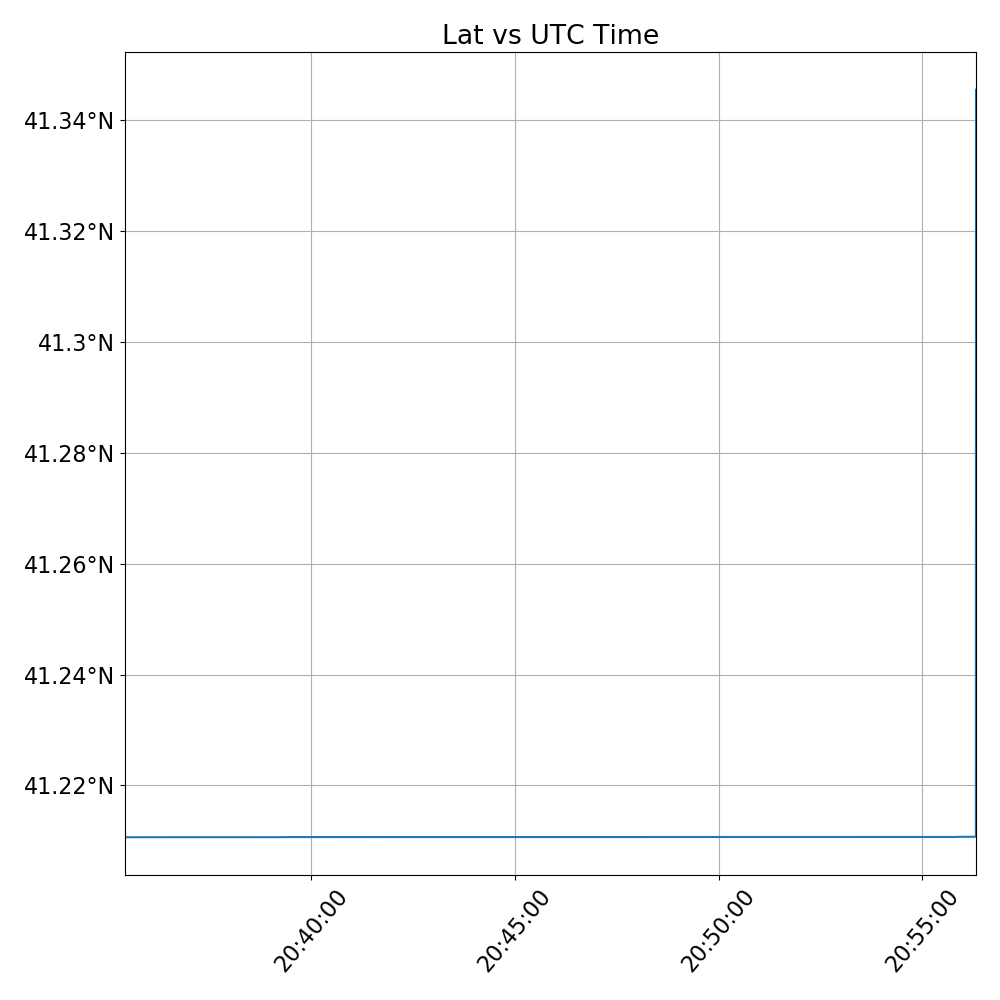

<IPython.core.display.Javascript object>


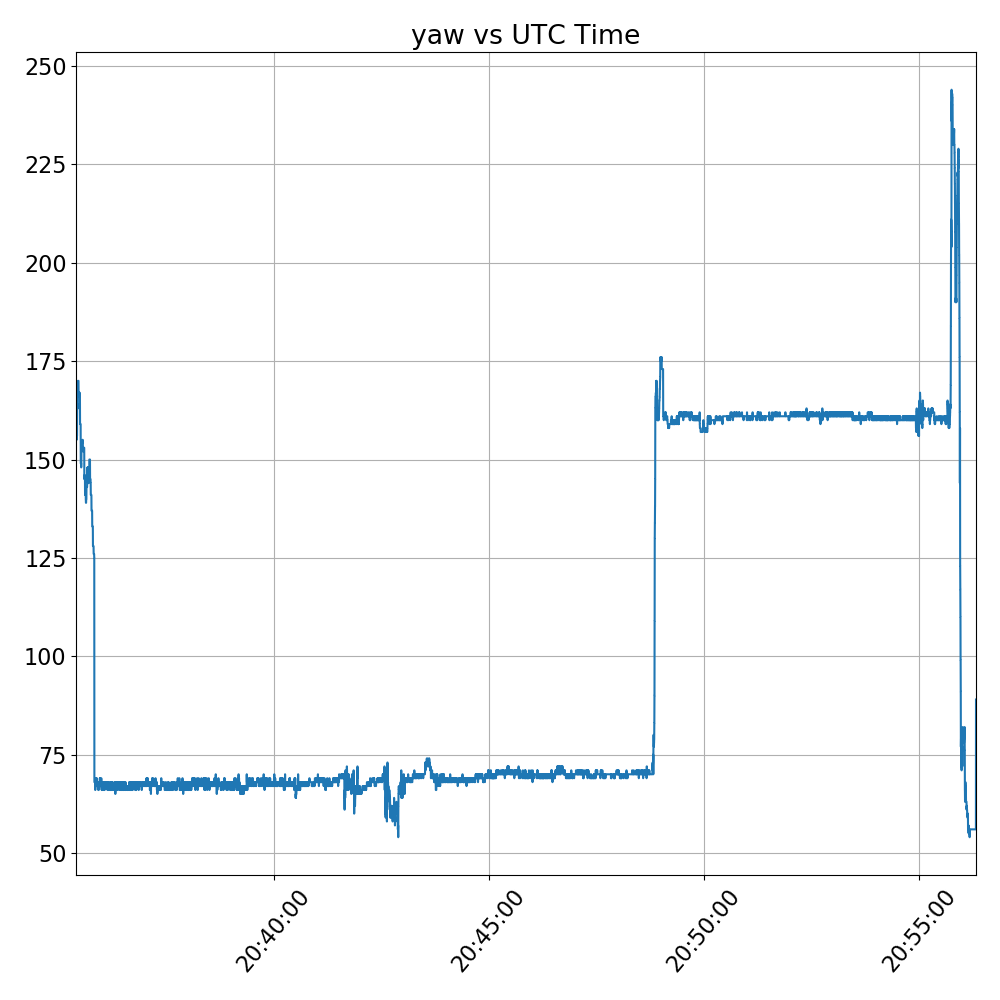

<IPython.core.display.Javascript object>


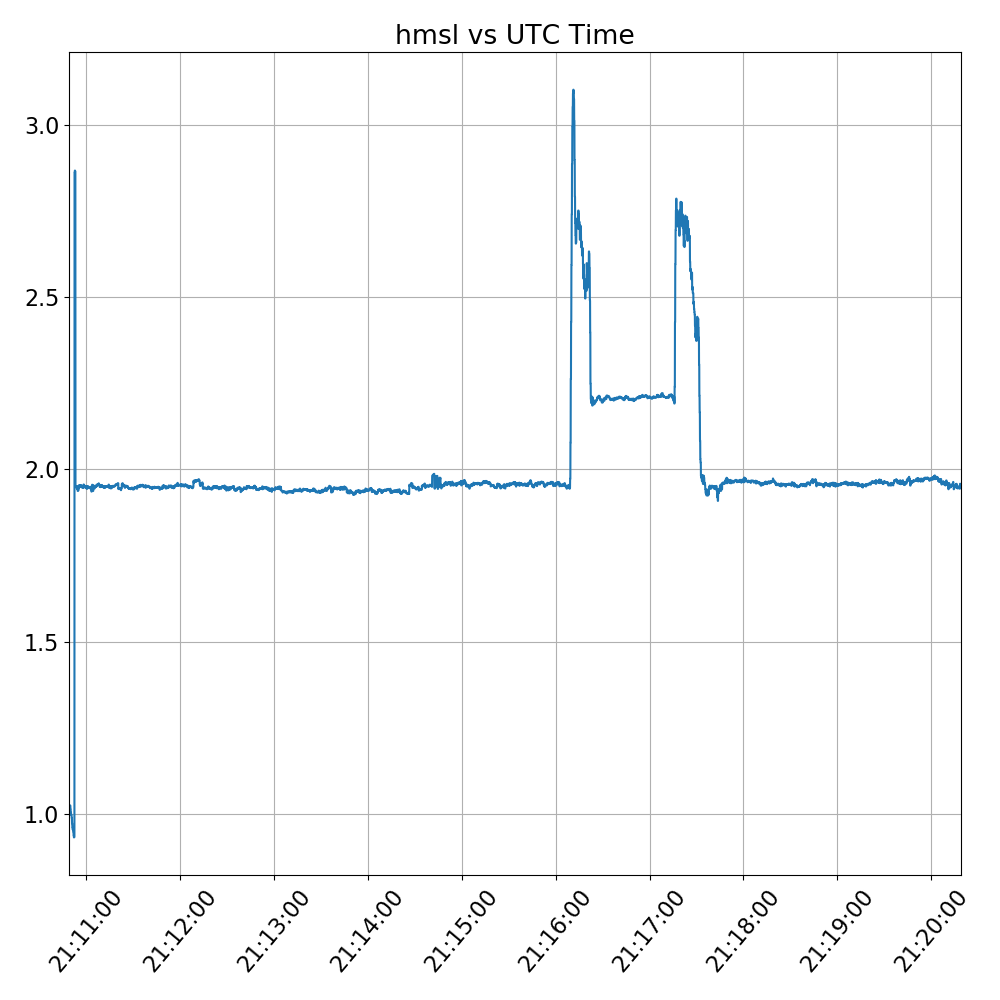

<IPython.core.display.Javascript object>


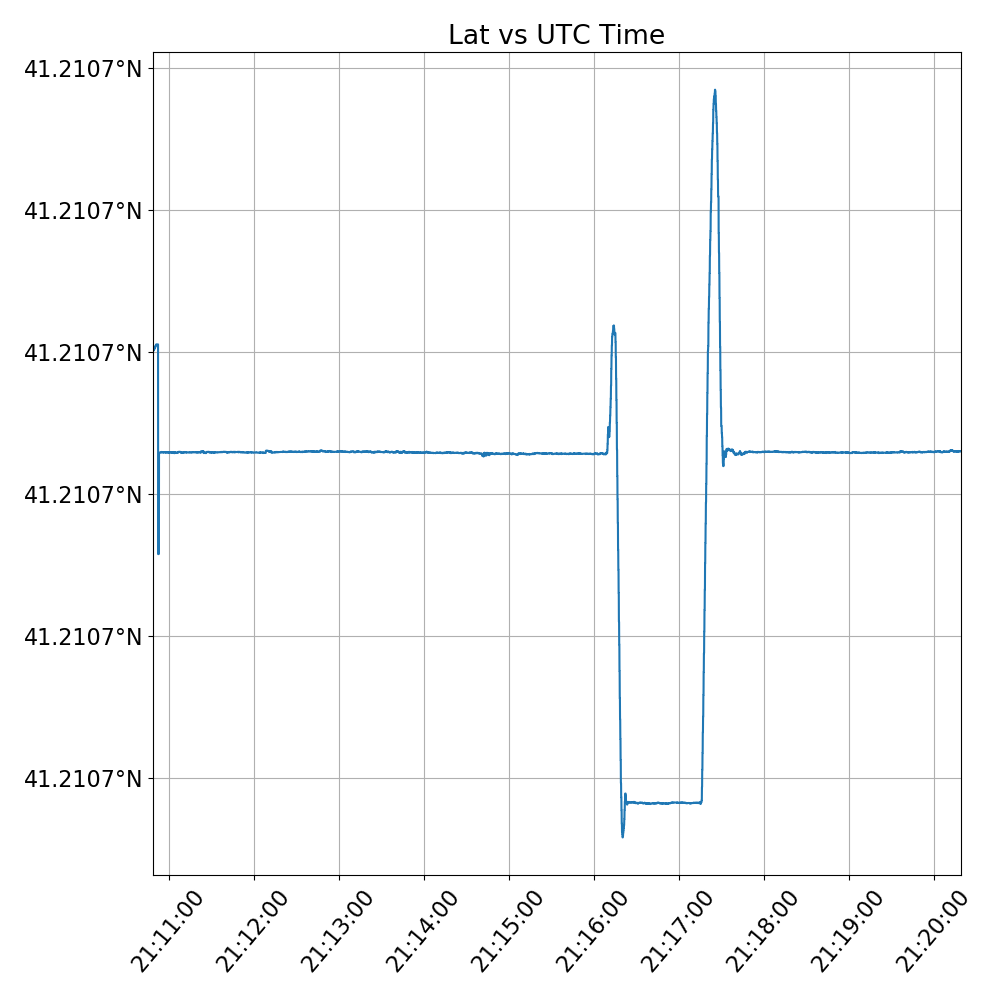

<IPython.core.display.Javascript object>


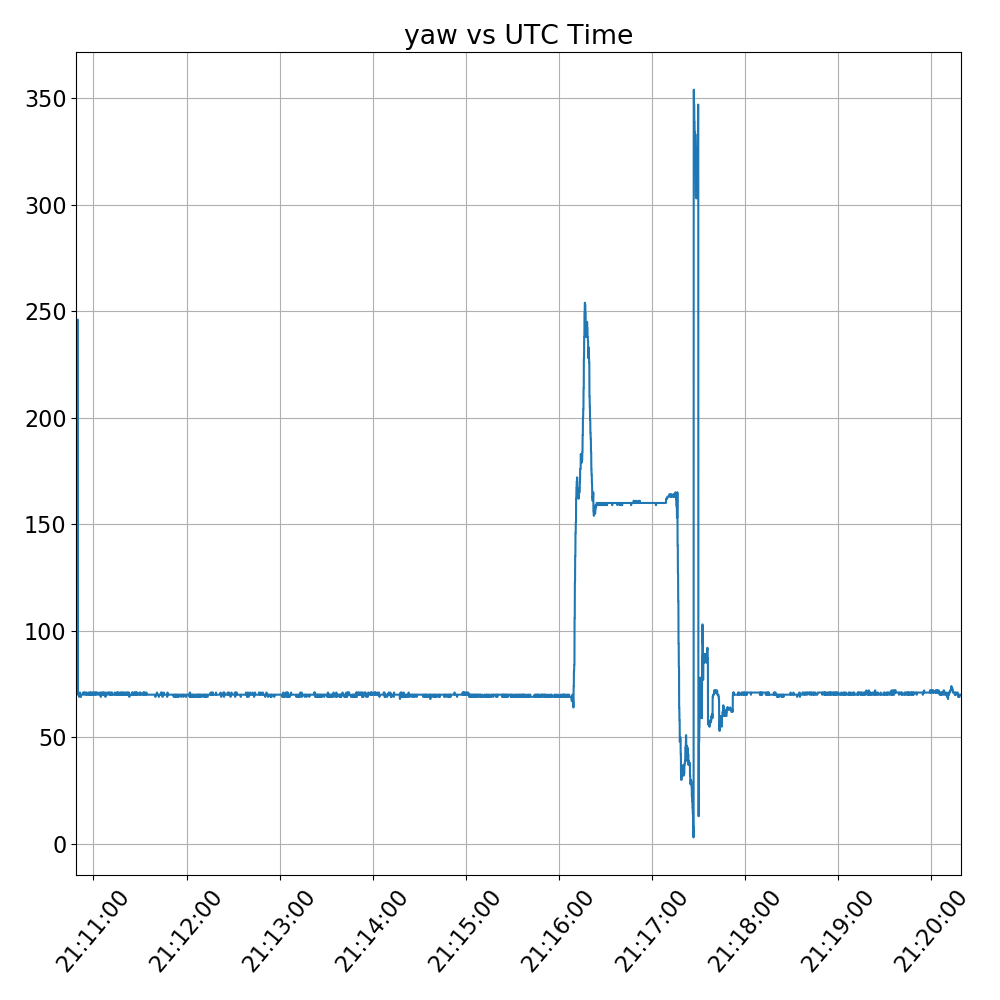

In [22]:
# Plot latitude, longitude, and height
#%matplotlib inline
#drone.plot_latitude(df, NAME)
#drone.plot_longitude(df, NAME)
#drone.plot_height(df, NAME)
#dat.plot('vel')
#dat.plot('Lon')

%matplotlib notebook
#dat.plot('yaw')
#dat.plot('vel')
#dat.plot('hmsl')
#dat.plot('Lat')
#dat.plot('Lon')
#drone.plot_control(df, NAME, view='vel')
for dat in drone_data:
    dat.plot('hmsl')
    dat.plot('Lat')
    dat.plot('yaw')

In [25]:

# reset the point column
for dat in drone_data: dat.df = dat.df.assign(point = np.full_like(dat.df['tick'].values, -1))

# mark points (2 in each frame)
if "FLY222" in NAMES:
    index = NAMES.index("FLY222")
    drone_data[index].mark_point(np.datetime64("2019-10-18T17:27:30"), np.datetime64("2019-10-18T17:27:45"))
    drone_data[index].mark_point(np.datetime64("2019-10-18T17:45:18"), max(drone_data[0].df['timestamp'].values))

if "FLY224" in NAMES:
    index = NAMES.index("FLY224")
    drone_data[index].mark_point(min(drone_data[1].df['timestamp'].values), np.datetime64("2019-10-18T17:57:29"))
    drone_data[index].mark_point(np.datetime64("2019-10-18T18:15:22"), max(drone_data[1].df['timestamp'].values))
    
if "FLY225" in NAMES:
    index = NAMES.index("FLY225")
    drone_data[index].mark_point(np.datetime64("2019-10-18T21:14:52"), np.datetime64("2019-10-18T21:15:30"))
    drone_data[index].mark_point(np.datetime64("2019-10-18T21:34:03"), max(drone_data[2].df['timestamp'].values))

if "FLY226" in NAMES:
    index = NAMES.index("FLY226")
    drone_data[index].mark_point(np.datetime64("2019-10-18T22:14:47"), np.datetime64("2019-10-18T22:14:55"))
    drone_data[index].mark_point(np.datetime64("2019-10-18T22:30:58"), max(drone_data[3].df['timestamp'].values))

if "FLY229" in NAMES:
    index = NAMES.index("FLY229")
    drone_data[index].mark_point(np.datetime64("2019-10-18T23:28:15"), np.datetime64("2019-10-18T23:28:40"))
    drone_data[index].mark_point(np.datetime64("2019-10-18T23:42:44"), max(drone_data[4].df['timestamp'].values))

if "FLY235" in NAMES:
    index = NAMES.index("FLY235")
    drone_data[index].mark_point(np.datetime64("2019-11-19T20:44:03"), np.datetime64("2019-11-19T20:48:40"))
    drone_data[index].mark_point(np.datetime64("2019-11-19T20:49:35"), np.datetime64("2019-11-19T20:54:40"))
    
if "FLY236" in NAMES:
    index = NAMES.index("FLY236")
    drone_data[index].mark_point(np.datetime64("2019-11-19T21:14:50"), np.datetime64("2019-11-19T21:16:05"))
    drone_data[index].mark_point(np.datetime64("2019-11-19T21:17:51"), np.datetime64("2019-11-19T21:20:00"))
    
points_latlon = []
points_local = []
distances = []
marker_dist = []

marker = (41.210662930555555, -73.04671158611111)
for dat in drone_data:
    points_latlon.append(dat.point_coords(0))
    points_latlon.append(dat.point_coords(1))
    points_local.append(dat.point_coords(0, local=True))
    points_local.append(dat.point_coords(1, local=True))
    distances.append(dat.between_points(0,1)[0])
    marker_dist.append(geopy.distance.distance(points_latlon[-1], marker).m)
    marker_dist.append(geopy.distance.distance(points_latlon[-2], marker).m)
    
print("POINTS LATLON")
print(points_latlon)
print("POINTS LOCAL")
print(points_local)
print("DISTANCES")
print(distances)
print("DISTANCES TO MARKER")
print(marker_dist)

print("East-West distance: "+str(geopy.distance.distance((marker[0],points_latlon[-1][1]),marker).m))
print("North-South distance: "+str(geopy.distance.distance(marker, (points_latlon[-1][0],marker[1])).m))

marking point
[False False False ... False False False]
marking point
[False False False ... False False False]
marking point
[False False False ... False False False]
marking point
[False False False ... False False False]
POINTS LATLON
[(41.210672738540495, -73.04671245107063), (41.21067275220998, -73.04671242659883), (41.21072283965182, -73.04673498279081), (41.21072294249239, -73.0467349828586)]
POINTS LOCAL
[(-0.07254140968097841, 1.0892563868357288), (-0.07048903743624868, 1.090774495003241), (-1.9622019021797668, 6.653385682258389), (-1.9622075848293414, 6.664806955558991)]
DISTANCES
[0.0025528151883222037, 0.011421267264311136]
DISTANCES TO MARKER
[1.0930483503933788, 1.0916678668245066, 6.947652886639101, 6.93669573823302]
East-West distance: 1.9622087754262945
North-South distance: 6.664804638035758


<IPython.core.display.Javascript object>


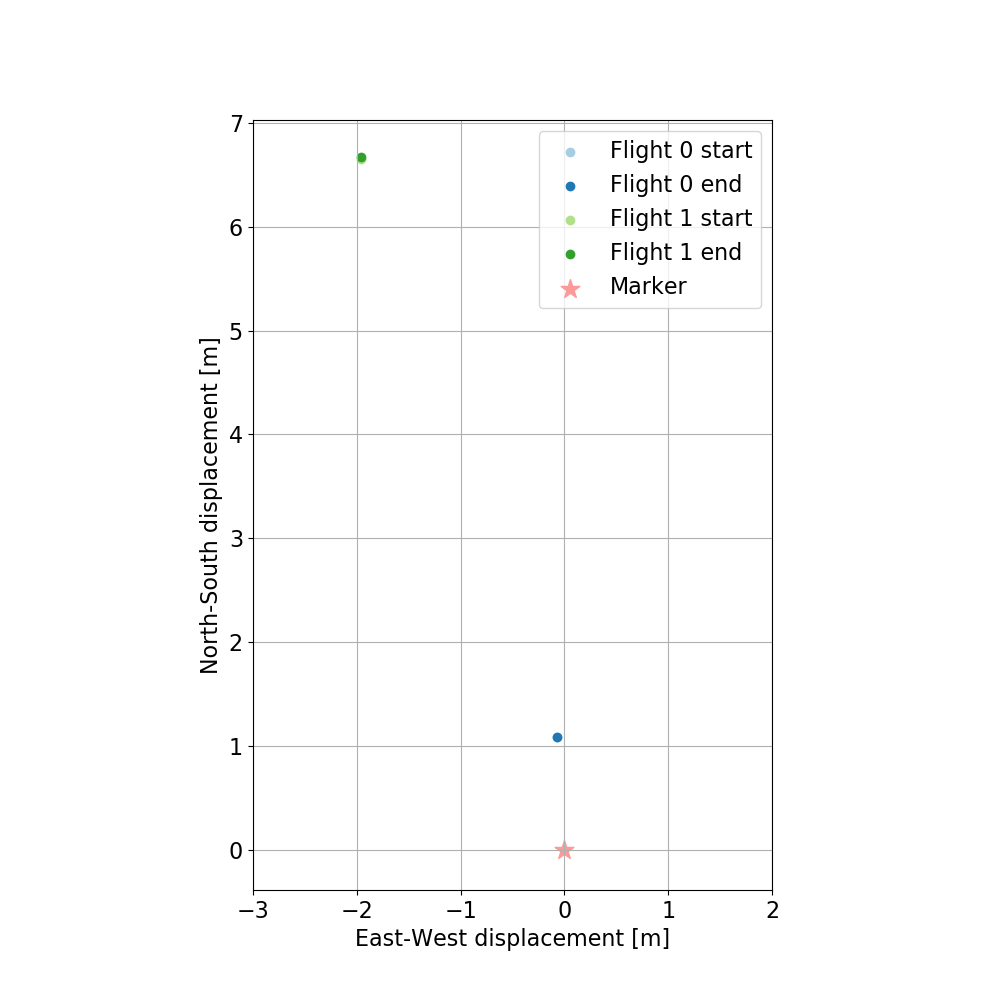

In [36]:
# Plot all the points, at meter scale, in color pairs
fig = plt.figure(figsize=(10,10))
cm = plt.get_cmap("Paired")
ax = plt.gca()
ax.set_prop_cycle(color=[cm(1.*i/12) for i in range(12)])
ax.set_aspect('equal')

for i in range(len(drone_data)):
    plt.scatter(points_local[2*i][0], points_local[2*i][1], label="Flight %d start"%i)
    plt.scatter(points_local[2*i + 1][0], points_local[2*i + 1][1], label="Flight %d end"%i)
plt.scatter(0,0, label="Marker", marker="*", s=200)

plt.xlabel("East-West displacement [m]")
plt.ylabel("North-South displacement [m]")

plt.xlim(-3, 2)

plt.legend()
plt.grid()
plt.show()
plt.savefig("./plots/return_to_point.png")

<IPython.core.display.Javascript object>


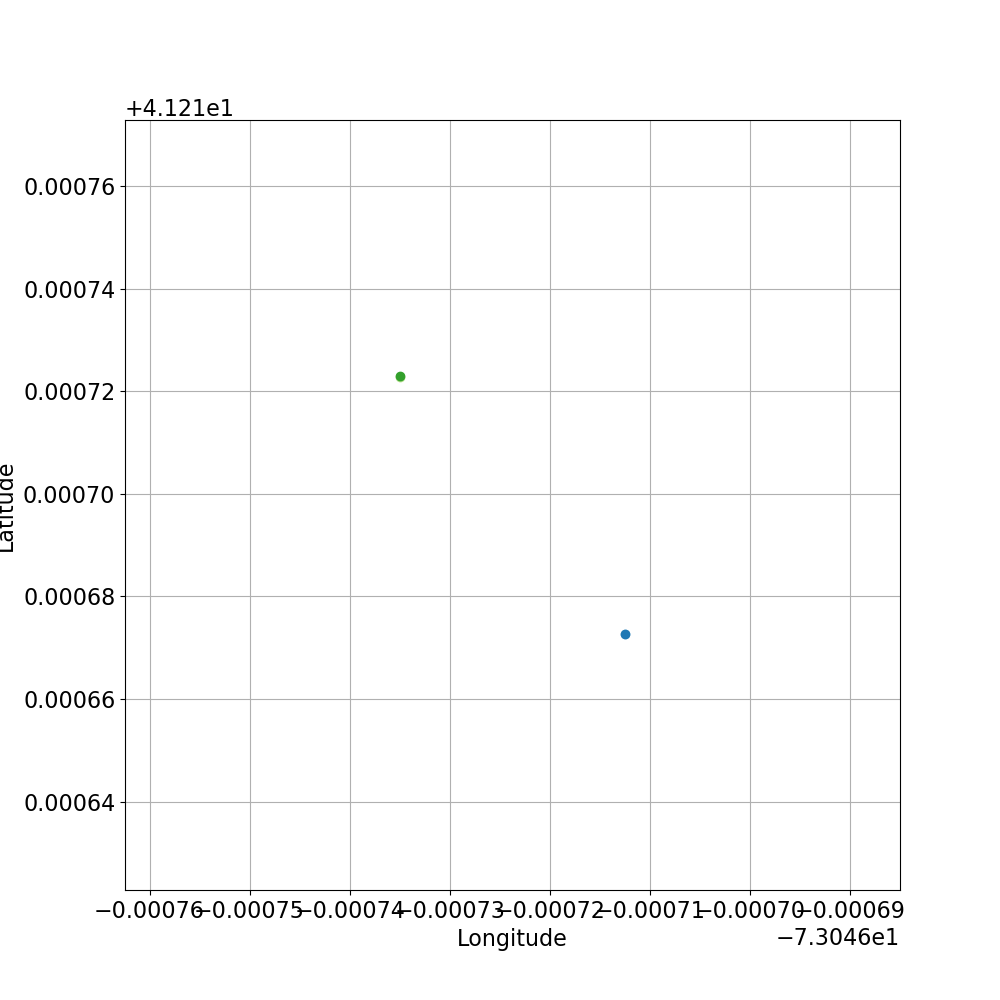

In [27]:
# Plot all the points, at meter scale, in color pairs
fig = plt.figure(figsize=(10,10))
cm = plt.get_cmap("Paired")
ax = plt.gca()
ax.set_prop_cycle(color=[cm(1.*i/12) for i in range(12)])
#ax.set_aspect('equal')

for i in range(len(drone_data)):
    plt.scatter(points_latlon[2*i][1], points_latlon[2*i][0], label="Flight %d start"%i)
    plt.scatter(points_latlon[2*i + 1][1], points_latlon[2*i + 1][0], label="Flight %d end"%i)
   
ax.set_xlim(min(points_latlon)[1]-0.00005, max(points_latlon)[1]+0.00005)
ax.set_ylim(min(points_latlon)[0]-0.00005, max(points_latlon)[0]+0.00005)

plt.xlabel("Longitude")
plt.ylabel("Latitude")

#plt.legend()
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


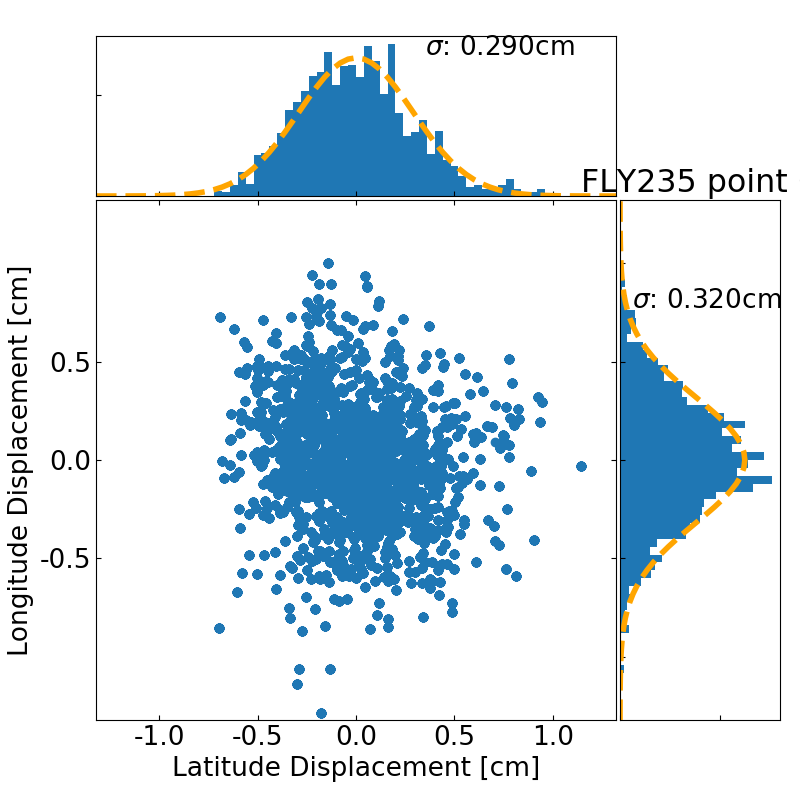

<IPython.core.display.Javascript object>


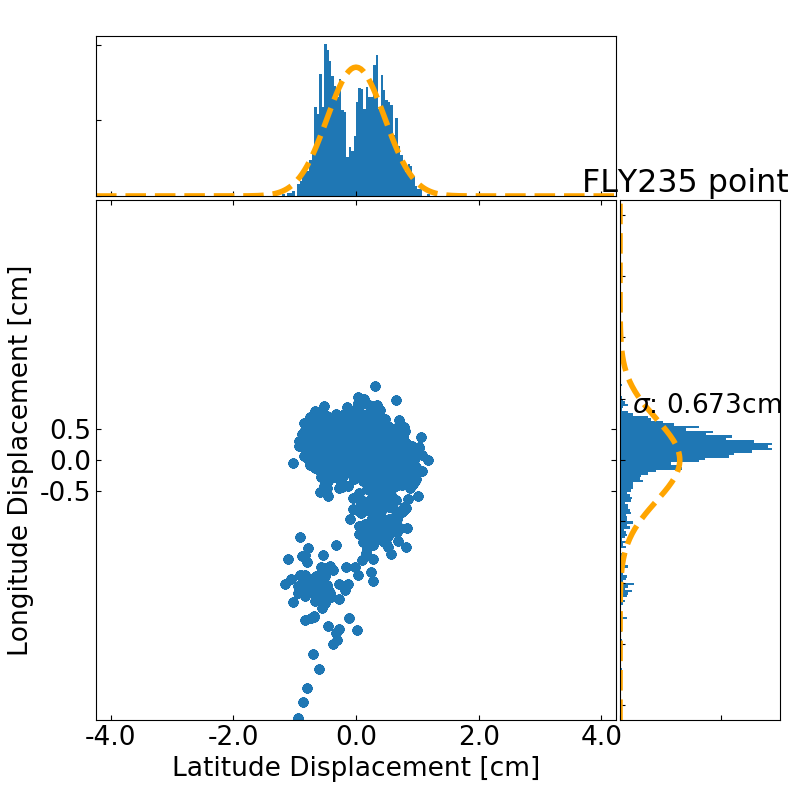

<IPython.core.display.Javascript object>


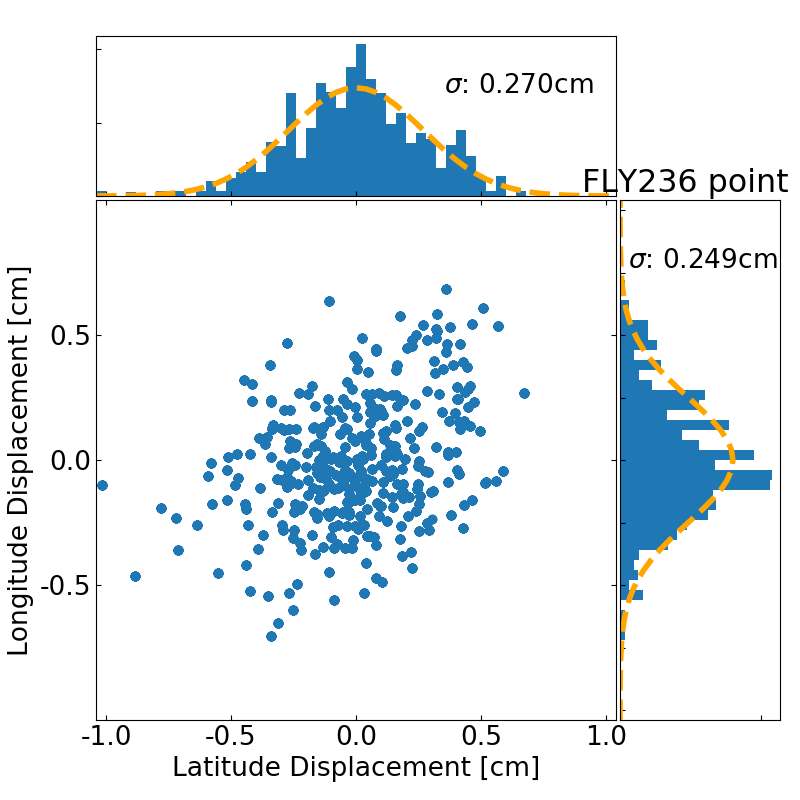

<IPython.core.display.Javascript object>


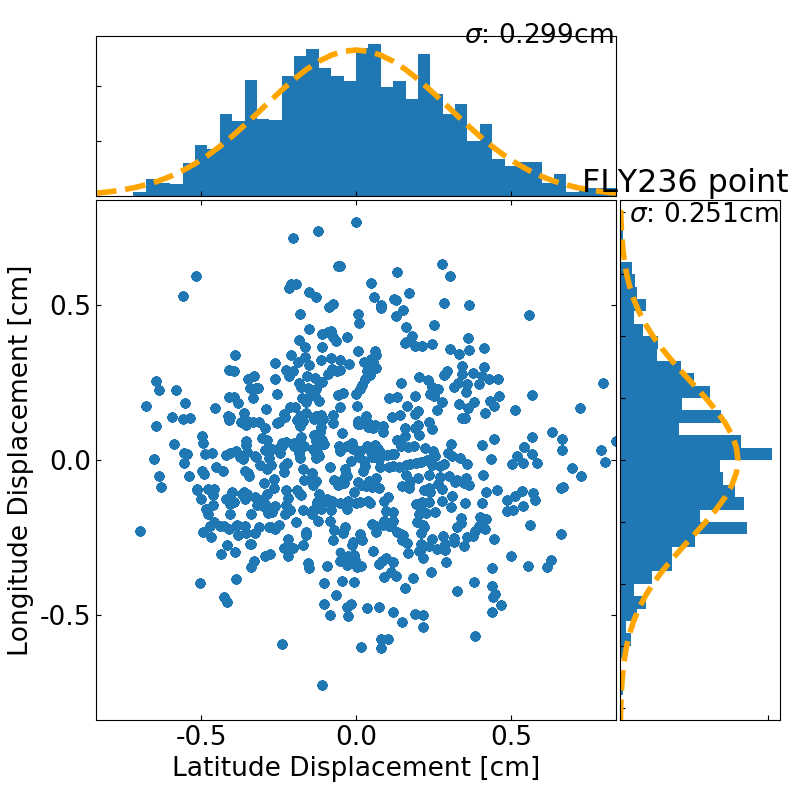

In [23]:
drone_data[0].point_hist(0)
drone_data[0].point_hist(1)
drone_data[1].point_hist(0)
drone_data[1].point_hist(1)
#drone_data[2].point_hist(0)
#drone_data[2].point_hist(1)
#drone_data[3].point_hist(0)
#drone_data[3].point_hist(1)
#drone_data[4].point_hist(0)
#drone_data[4].point_hist(1)
